In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [39]:
# Load the dataset
data = pd.read_csv('../input/breakhis/Folds.csv')

In [40]:
# Define the image directory
img_dir = '../input/breakhis/BreaKHis_v1/'

In [41]:
# Prepare the data
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: 1 if x == 'malignant' else 0)
data['filename'] = data.path.apply(lambda x: os.path.join(img_dir, x))

In [42]:
# Split the data
X = data['filename']
y = data['label_int']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [43]:
# Ensure 'label_int' column values are strings
data['label_int'] = data['label_int'].astype(str)

In [44]:
# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [45]:
# Freeze the base model
base_model.trainable = False

In [46]:
# Build the model
model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
    ])

In [47]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [49]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print(data.head())

   fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

    label label_int                                           filename  
0  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
1  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
2  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
3  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
4  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  


In [50]:
# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data.loc[data.index.isin(X_train.index)],
    x_col='filename',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=data.loc[data.index.isin(X_val.index)],
    x_col='filename',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data.loc[data.index.isin(X_test.index)],
    x_col='filename',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 31636 validated image filenames belonging to 2 classes.
Found 3954 validated image filenames belonging to 2 classes.
Found 3955 validated image filenames belonging to 2 classes.


In [51]:
# Debugging: Check the number of samples
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Training samples: 31636
Validation samples: 3954
Test samples: 3955


In [52]:
# Ensure that the generators have data
if train_generator.samples == 0:
    raise ValueError("No training images found. Check the training directory.")
if val_generator.samples == 0:
    raise ValueError("No validation images found. Check the validation directory.")
if test_generator.samples == 0:
    raise ValueError("No test images found. Check the test directory.")

In [53]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [54]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/988 ━━━━━━━━━━━━━━━━━━━━ 1:30 92ms/step - accuracy: 0.4531 - loss: 0.9045  

W0000 00:00:1721739955.659658     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


265/988 ━━━━━━━━━━━━━━━━━━━━ 8:47 730ms/step - accuracy: 0.6117 - loss: 0.7122

W0000 00:00:1721740148.269571     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.6452 - loss: 0.6696

W0000 00:00:1721740671.436620     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 785s 778ms/step - accuracy: 0.6452 - loss: 0.6695 - val_accuracy: 0.6799 - val_loss: 0.6151
Epoch 2/10
  1/988 ━━━━━━━━━━━━━━━━━━━━ 1:26 88ms/step - accuracy: 0.5625 - loss: 0.7693

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 0.7693 - val_accuracy: 0.6111 - val_loss: 0.6454
Epoch 3/10


W0000 00:00:1721740725.562528     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 775s 779ms/step - accuracy: 0.6853 - loss: 0.6158 - val_accuracy: 0.6959 - val_loss: 0.6061
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - accuracy: 0.7500 - loss: 0.5667 - val_accuracy: 0.6111 - val_loss: 0.7082
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 763s 768ms/step - accuracy: 0.6879 - loss: 0.6142 - val_accuracy: 0.6972 - val_loss: 0.6041
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.5938 - loss: 0.6562 - val_accuracy: 0.5556 - val_loss: 0.6618
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 765s 769ms/step - accuracy: 0.6973 - loss: 0.6064 - val_accuracy: 0.6941 - val_loss: 0.6021
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.6250 - loss: 0.6871 - val_accuracy: 0.7778 - val_loss: 0.5104
Epoch 9/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 764s 768ms/step - accuracy: 0.6937 - loss: 0.6065 - val_accuracy: 0.6872 - val_loss: 0.6023
Epoch 10/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 135us/step - accuracy: 0.7188 - loss: 0.5545 - val

In [55]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [56]:
# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/5
  2/988 ━━━━━━━━━━━━━━━━━━━━ 1:41 103ms/step - accuracy: 0.6562 - loss: 0.8070 

W0000 00:00:1721743863.686303     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


647/988 ━━━━━━━━━━━━━━━━━━━━ 4:10 735ms/step - accuracy: 0.6944 - loss: 0.5929

W0000 00:00:1721744338.558319     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7063 - loss: 0.5757

W0000 00:00:1721744586.350089     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 798s 785ms/step - accuracy: 0.7063 - loss: 0.5756 - val_accuracy: 0.7802 - val_loss: 0.4865
Epoch 2/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.3918 - val_accuracy: 0.6111 - val_loss: 0.7433
Epoch 3/5


W0000 00:00:1721744640.034157     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 769s 773ms/step - accuracy: 0.7927 - loss: 0.4608 - val_accuracy: 0.7990 - val_loss: 0.4605
Epoch 4/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.7812 - loss: 0.4494 - val_accuracy: 0.7222 - val_loss: 0.6406
Epoch 5/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 766s 770ms/step - accuracy: 0.8067 - loss: 0.4388 - val_accuracy: 0.8105 - val_loss: 0.4263


In [58]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

123/123 ━━━━━━━━━━━━━━━━━━━━ 53s 426ms/step - accuracy: 0.8021 - loss: 0.4510
Test Loss: 0.4391
Test Accuracy: 0.8056


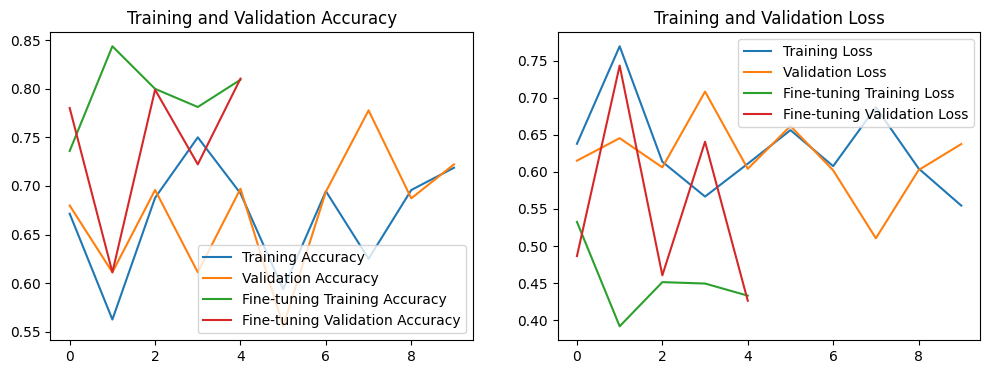

In [59]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuning Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()